In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/encoded_data.csv')
seed = 42  # for reproducibility

In [2]:
df.shape

(16731, 132)

In [3]:
df.dropna(inplace=True)
df.shape

(14325, 132)

In [4]:
response = 'Price'

X = df.drop([response], axis=1)
y = df[response]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)

# store shapes in dictionary to prepare for printing
shapes = {
	'X': {
		'train': str(X_train.shape),
		'val':   str(X_val.shape),
		'test':  str(X_test.shape),
	},
	'y': {
		'train': str(y_train.shape),
		'val':   str(y_val.shape),
		'test':  str(y_test.shape),
	}
}

# find maximum widths of
# [0] split names
# [1] X shapes
# [2] y shapes
maxes = list(map(
	lambda shape_list: len(max(shape_list, key=len)),
	[shapes['X'].keys(), shapes['X'].values(), shapes['y'].values()]
))

# print with found widths
for split, shape in shapes['X'].items():
	print(
		f'X_{split:<{maxes[0]}}: {shape:<{maxes[1]}} / '
		f'y_{split:<{maxes[0]}}: {shapes['y'][split]:<{maxes[2]}}'
	)

X_train: (10743, 131) / y_train: (10743,)
X_val  : (1791, 131)  / y_val  : (1791,) 
X_test : (1791, 131)  / y_test : (1791,) 


In [5]:
alphas = list(sorted(set(
	[(alpha**2)/10 for alpha in range(1, 11)] + [ratio / 10 for ratio in range(1, 30)]
)))
l1_ratios = np.arange(0, 1, 0.1).tolist()


In [6]:
print(alphas)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.6, 4.9, 6.4, 8.1, 10.0]


In [11]:
def parameter_search(
	method: str, 
	estimator = ElasticNet(max_iter=100_000), 
	params = {'alpha': alphas, 'l1_ratio': l1_ratios},
	scoring = 'r2',
	cv: int = 3,
):
	match method:
		case 'random':
			searcher = RandomizedSearchCV(
				estimator = estimator,
				param_distributions = params,
				scoring = scoring,
				cv = cv,
				random_state = seed,
			)
		case 'grid':
			searcher = GridSearchCV(
				estimator = ElasticNet(),
				param_grid = params,
				scoring = scoring,
				cv = cv,
			)

	#searcher.fit(X_train, y_train)
	searcher.fit(StandardScaler().fit_transform(X_train), y_train)

	best_alpha = searcher.best_params_['alpha']
	best_l1 = searcher.best_params_['l1_ratio']
	
	print(
		f"The optimal value of alpha is {best_alpha} and "
		f"for l1_ratio {best_l1} based on {method} search."
	)
	
	return best_alpha, best_l1

In [8]:
best_alpha_random, best_l1_random = parameter_search('random')

The optimal value of alpha is 0.3 and for l1_ratio 0.5 based on random search.


In [12]:
best_alpha_grid, best_l1_grid = parameter_search('grid')
# will was here last, not sure how to fix the convergence warning, but i think its important 
# since it gives so many errors

/home/me/Documents/python_virtual_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.511e+11, tolerance: 5.475e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/me/Documents/python_virtual_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.907e+11, tolerance: 5.398e+08 Linear regression models with null weight for the l1 regularization term are more efficien

KeyboardInterrupt: 

In [1]:
%matplotlib inline

alphasToTest = [best_alpha_random, best_alpha_grid]
l1_ratiosToTest = [best_l1_random, best_l1_grid]
scores = []
for alpha, ratio in zip(alphasToTest, l1_ratiosToTest):
	reg_mod = ElasticNet(alpha=alpha, l1_ratio=ratio)
	reg_mod.fit(X_train, y_train)
	y_pred = reg_mod.predict(X_val)
	scores.append(r2_score(y_val, y_pred))

plt.figure(figsize=(10, 6))
ax = sns.barplot(x = ["RandomizedSearchCV","GridSearchCV"] , y=scores)
ax.set(ylim=(0, 1))
plt.title('R2 Score for ElasticNet using RandomizedSearchCV and GridSearchCV')
plt.show()

NameError: name 'best_alpha_random' is not defined

The above results shows, that there is no significant difference between the results of RandomizedSearch and GridSearch, however as the RandomizedSearch significanty outperforms the GridSearch in computational time, the RnadomizedSearch is the preferred method to use. However it must be mentioned, that there was a significant difference between the tuned parameters.

In [91]:
# Examine the 
r2_scorer = make_scorer(r2_score, greater_is_better=True)
randomized_search = GridSearchCV(estimator=Ridge(), param_grid={'alpha': alphas}, scoring=r2_score, cv=3)
randomized_search.fit(X_train, y_train)
best_alpha_random_ridge = randomized_search.best_params_['alpha']
print(f"The optimal value of alpha is {best_alpha_random_ridge} based on Randomized search for Ridge regression.")

c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
c:\Users\zsomb\anaconda3\lib

The optimal value of alpha is 0.0 based on Randomized search for Ridge regression.


In [92]:
best_alpha_random_ridge

0.0

In [62]:
MAPE_scorer = make_scorer(r2_score, greater_is_better=True)
randomized_search = GridSearchCV(estimator=Lasso(), param_grid={'alpha': alphas}, scoring=MAPE_scorer, cv=3)
randomized_search.fit(X_train, y_train)
best_alpha_random_lasso = randomized_search.best_params_['alpha']
print(f"The optimal value of alpha is {best_alpha_random_lasso} based on Randomized search for Lasso regression.")

c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e+11, tolerance: 5.475e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.190e+11, tolerance: 5.398e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.287e+11, toleranc

The optimal value of alpha is 8.1 based on Randomized search for Ridge regression.


In [63]:
alphasToTest = [best_alpha_random, best_alpha_gird, best_alpha_random_ridge, best_alpha_random_lasso]
l1_ratiosToTest = [best_l1_random, best_l1_gird]
Results = {} #['ElasticNet Randomized', 'ElasticNet Grid', 'Ridge Randomized', 'Lasso Randomized']
# ElasticNet Randomized
reg_mod = ElasticNet(alpha=alphasToTest[0], l1_ratio=l1_ratiosToTest[0])
reg_mod.fit(X_train, y_train)
y_pred = reg_mod.predict(X_val)
r2 = r2_score(y_val, y_pred)
Results['ElasticNet using Randomized search'] = r2
# ElasticNet Grid
reg_mod = ElasticNet(alpha=alphasToTest[1], l1_ratio=l1_ratiosToTest[1])
reg_mod.fit(X_train, y_train)
y_pred = reg_mod.predict(X_val)
r2 = r2_score(y_val, y_pred)
Results['ElasticNet using Grid search'] = r2
# Ridge Randomized
reg_mod = Ridge(alpha=alphasToTest[2])
reg_mod.fit(X_train, y_train)
y_pred = reg_mod.predict(X_val)
r2 = r2_score(y_val, y_pred)
Results['Ridge Regression'] = r2
# Laso Randomized
reg_mod = Lasso(alpha=alphasToTest[3])
reg_mod.fit(X_train, y_train)
y_pred = reg_mod.predict(X_val)
r2 = r2_score(y_val, y_pred)
Results['Lasso Regression'] = r2

c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e+12, tolerance: 8.203e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


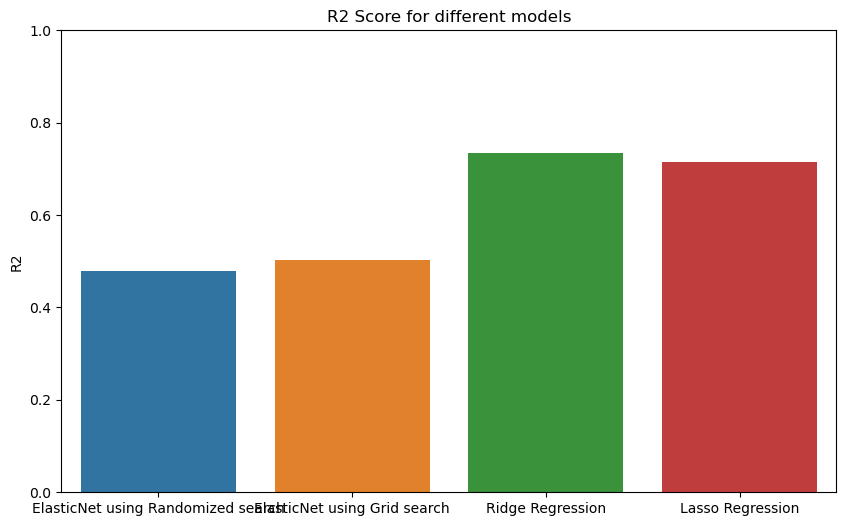

In [64]:
results_df = pd.DataFrame.from_dict(Results, orient='index', columns=['R2'])
plt.figure(figsize=(10, 6))
ax = sns.barplot(x = results_df.index , y=results_df.R2)
ax.set(ylim=(0, 1))
plt.title('R2 Score for different models')
plt.savefig('diagrams/model_check.png')
plt.show()
#results_df.plot(kind='bar', rot=45, legend=False, title='R2 for different models')

In [65]:
results_df

,R2
ElasticNet using Randomized search,0.478827
ElasticNet using Grid search,0.503459
Ridge Regression,0.735180
Lasso Regression,0.713869


<Axes: >

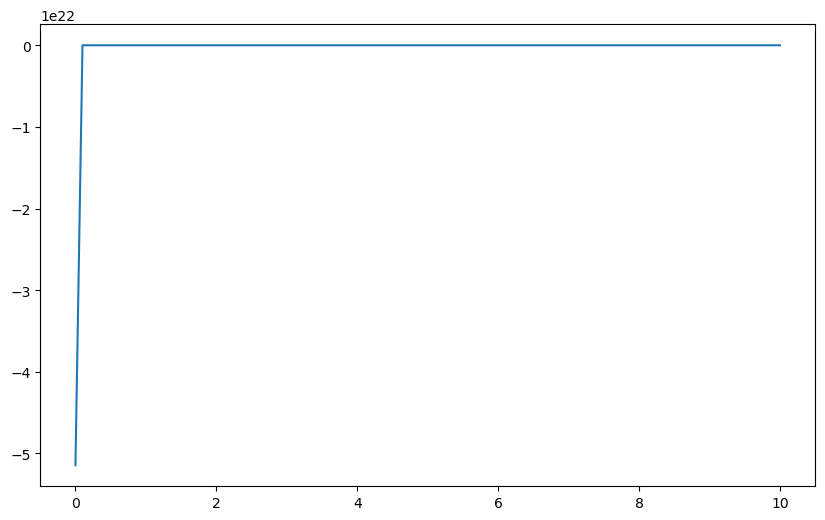

In [93]:
r2_scores = []
for alpha in alphas:
    reg_mod = Ridge(alpha=alpha)
    reg_mod.fit(X_train, y_train)
    y_pred = reg_mod.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    r2_scores.append(r2)
    #print(f'alpha: {alpha} / MAPE: {mape}')
plt.figure(figsize=(10, 6))
sns.lineplot(x=alphas, y=r2_scores)

In [101]:
reg_mod = Ridge(alpha = 0.01)
reg_mod.fit(X_train, y_train)
y_pred = reg_mod.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

0.7417062437352155